In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
# from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils


In [ ]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged


In [ ]:
def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [ ]:
def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_size = (120,120)

In [27]:
# Open 
image = cv2.imread('/content/drive/My Drive/blood_classification/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_0_224.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
# add padding to the image to better detect cell at the edge
image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
               
#thresholding the image to get the target cell
image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
               
# openning errosion then dilation
kernel = np.ones((3, 3), np.uint8)
kernel1 = np.ones((5, 5), np.uint8)
img_erosion = cv2.erode(image1, kernel, iterations=2)
image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
               
#detecting the blood cell
edgedImage = findEdges(image1)
edgedContours = getImgContours(edgedImage)
edgedBoxes =  getBoxes(edgedContours, image.copy())

# get the large box and get its cordinate
last = edgedBoxes[-1]
max_x = int(max(last[:,0]))
min_x = int( min(last[:,0]))
max_y = int(max(last[:,1]))
min_y = int(min(last[:,1]))
                
# draw the contour and fill it 
mask = np.zeros_like(image)
cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
# any pixel but the pixels inside the contour is zero
image[mask==0] = 0
                
# extract th blood cell
image = image[min_y:max_y, min_x:max_x]
# resize th image
image = cv2.resize(image, image_size)

In [28]:
image = image / 255.0 

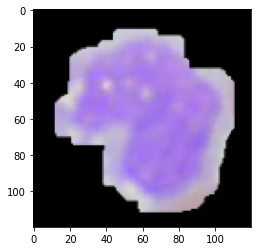

In [29]:
plt.imshow(image)
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Bloodcell_Classification_Model1_Custom_Build_10_epochs.h5')

In [30]:
image = np.expand_dims(image, axis=0)

In [33]:
prediction = new_model.predict(image)
prediction = np.argmax(prediction,axis=1)

In [34]:
prediction

array([2])